In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
seaborn.set_style('dark')
np.set_printoptions(precision=3)

%matplotlib inline

In [2]:
import sklearn
import sklearn.metrics
import sklearn.grid_search
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.preprocessing
import sklearn.pipeline
import pescador

In [3]:
import glob

In [4]:
def load_file(filename, n_pos=32, n_neg=32):
    
    data = np.load(filename)
    
    d = data['X'].shape[1]
    
    if n_pos is None:
        return data['X'], data['Y']
    
    
    positives = np.flatnonzero(data['Y'])
    negatives = np.flatnonzero(1-data['Y'])
    n_pos = min(n_pos, len(positives))
    n_neg = min(n_neg, len(negatives))
    
    X = np.empty((n_pos + n_neg, d), dtype=np.float32)
    Y = np.zeros((n_pos + n_neg), dtype=np.int32)
    
    if n_pos > 0:
        idx_pos = np.random.choice(positives, size=n_pos, replace=False)
    
        X[:n_pos] = np.take(data['X'], idx_pos, axis=0)
        Y[:n_pos] = 1
    
    if n_neg > 0:
        idx_neg = np.random.choice(negatives, size=n_neg, replace=False)
        X[n_pos:] = np.take(data['X'], idx_neg, axis=0)
    
    return X, Y

In [5]:
def load_batch(files, n_pos=32, n_neg=32):
    
    X = []
    Y = []
    
    for fn in files:
        _x, _y = load_file(fn, n_pos=n_pos, n_neg=n_neg)
        X.append(_x)
        Y.append(_y)
        
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    
    return X, Y

In [107]:
files = sorted(glob.glob('../data/labeled_features/SALAMI_*.npz'))
#files = sorted(glob.glob('../data/labeled_features/Isophonics_*.npz'))

In [108]:
filesplitter = sklearn.cross_validation.ShuffleSplit(len(files), n_iter=1, test_size=0.20, random_state=5)
_files = np.asarray(files)

In [109]:
for trainf, testf in filesplitter:
    
    print 'Loading training data...'
    X_train, Y_train = load_batch([_files[_] for _ in trainf],
                                 n_pos=64,
                                 n_neg=96)
    
    estimator = sklearn.linear_model.SGDClassifier(loss='log',
                                                   verbose=1)
    
    feature = sklearn.preprocessing.StandardScaler()
    
    _model = sklearn.grid_search.GridSearchCV(estimator,
                                             {'alpha': np.logspace(-3, 3, num=6, endpoint=False),
                                             'penalty': ['l1', 'l2', 'elasticnet']},
                                             n_jobs=3, verbose=1)
    
    model = sklearn.pipeline.Pipeline([('scaler', feature), ('predictor', _model)])
    
    model.fit(X_train, Y_train)
    
    print 'Loading testing data...'
    X_test, Y_test = load_batch([_files[_] for _ in testf],
                                n_pos=None,
                                n_neg=None)

Loading training data...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=3)]: Done   1 jobs       | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done  50 out of  54 | elapsed:  1.1min remaining:    5.3s
[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:  1.2min finished


-- Epoch 1
Norm: 0.08, NNZs: 924, Bias: -0.325539, T: 68660, Avg. loss: 0.601806-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 418.89, NNZs: 559, Bias: -13.927502, T: 45774, Avg. loss: 41.128848Norm: 408.00, NNZs: 561, Bias: -16.314957, T: 45773, Avg. loss: 39.680807Norm: 413.04, NNZs: 555, Bias: -14.067840, T: 45773, Avg. loss: 40.855370


Total training time: 0.57 seconds.
Total training time: 0.53 seconds.
Total training time: 0.64 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 416.57, NNZs: 140, Bias: -0.596051, T: 91548, Avg. loss: 22.064629Norm: 405.85, NNZs: 133, Bias: -0.698202, T: 91546, Avg. loss: 21.237161Norm: 410.50, NNZs: 139, Bias: -0.657805, T: 91546, Avg. loss: 21.956683


Total training time: 0.99 seconds.
Total training time: 1.16 seconds.
Total training time: 1.27 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 417.15, NNZs: 89, Bias: -0.451553, T: 137322, Avg. loss: 14.918995Norm: 406.39, NNZs: 77, Bias: -0.560305, T: 137319, Avg. loss: 14.364068Norm: 411.07, NNZs: 95, Bi

In [110]:
w = model.steps[1][1].best_estimator_.coef_[0]

In [111]:
w = w.reshape((-1, 84))

<matplotlib.colorbar.Colorbar instance at 0x7f29785fa3b0>

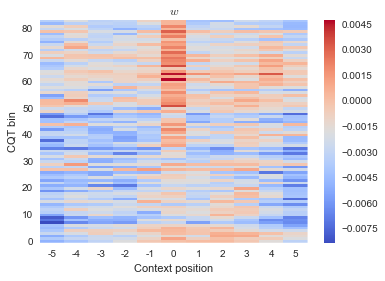

In [112]:
plt.imshow(w.T, aspect='auto', interpolation='none', cmap='coolwarm', origin='lower')
plt.ylabel('CQT bin')
plt.xlabel('Context position')
plt.title('$w$')
plt.xticks(np.arange(11), np.arange(-5, 6))
plt.colorbar()

In [113]:
print sklearn.metrics.classification_report(Y_train, model.predict(X_train))

             precision    recall  f1-score   support

          0       0.74      0.64      0.69     38834
          1       0.60      0.70      0.65     29826

avg / total       0.68      0.67      0.67     68660



In [ ]:
sklearn.metrics.accuracy_score(Y_train, model.predict(X_train))

0.66714244101369069

In [ ]:
Y_pred = [model.predict(xt) for xt in X_test]

In [ ]:
Y_pred = np.concatenate(Y_pred, axis=0)

In [ ]:
print sklearn.metrics.classification_report(Y_test, Y_pred)

In [ ]:
sklearn.metrics.accuracy_score(Y_test, Y_pred)

In [ ]:
import cPickle as pickle

In [106]:
pickle.dump({'model': model, 'dataset': 'salami'}, open('../data/similarity_model_salami.pickle', 'w'))
#pickle.dump({'model': model, 'dataset': 'isophonics'}, open('../data/similarity_model_isophonics.pickle', 'w'))